# Write summaries

TensorBoard helps us to summerize important parameters (such as wieghts, biases, activations, accuracy, ...) in order to see how each parameter changes in each iteration of the training.

We can also see the images using TensorBoard

## Imports:
We will start with importing the needed libraries for our code.

In [1]:
# imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Input data:
For this tutorial we use the MNIST dataset. MNIST is a dataset of handwritten digits. If you are into machine learning, you might have heard of this dataset by now. MNIST is kind of benchmark of datasets for deep learning. One other reason that we use the MNIST is that it is easily accesible through Tensorflow. If you want to know more about the MNIST dataset you can check Yann Lecun's website.
We can easily import the dataset and see the size of training, test and validation set:

In [2]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

print("Size of:")
print("- Training-set:\t\t{}".format(len(mnist.train.labels)))
print("- Test-set:\t\t{}".format(len(mnist.test.labels)))
print("- Validation-set:\t{}".format(len(mnist.validation.labels)))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


## Hyper-parameters:
Hyper-parameters are important parameters which are not learned by the network. So, we have to specify them externally. These parameters are constant and they are not learnable.

In [3]:
# hyper-parameters
logs_path = "./logs/write_summaries"  # path to the folder that we want to save the logs for TensorBoard
learning_rate = 0.001  # The optimization learning rate
epochs = 10  # Total number of training epochs
batch_size = 100  # Training batch size
display_freq = 100  # Frequency of displaying the training results

# Network Parameters
# We know that MNIST images are 28 pixels in each dimension.
img_h = img_w = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_h * img_w

# Number of classes, one class for each of 10 digits.
n_classes = 10

# number of units in the first hidden layer
h1 = 200

##  Graph:
Like before, we start by constructing the graph. But, we need to define some functions that we need rapidly in our code.

To visualize the parameters, we will use ```tf.summary``` class to write the summaries of parameters.

Notice ```tf.summary.histogram()```__ functions added to the code.

In [4]:
# weight and bais wrappers
def weight_variable(name, shape):
    """
    Create a weight variable with appropriate initialization
    :param name: weight name
    :param shape: weight shape
    :return: initialized weight variable
    """
    initer = tf.truncated_normal_initializer(stddev=0.01)
    return tf.get_variable('W_' + name,
                           dtype=tf.float32,
                           shape=shape,
                           initializer=initer)


def bias_variable(name, shape):
    """
    Create a bias variable with appropriate initialization
    :param name: bias variable name
    :param shape: bias variable shape
    :return: initialized bias variable
    """
    initial = tf.constant(0., shape=shape, dtype=tf.float32)
    return tf.get_variable('b_' + name,
                           dtype=tf.float32,
                           initializer=initial)


def fc_layer(x, num_units, name, use_relu=True):
    """
    Create a fully-connected layer
    :param x: input from previous layer
    :param num_units: number of hidden units in the fully-connected layer
    :param name: layer name
    :param use_relu: boolean to add ReLU non-linearity (or not)
    :return: The output array
    """
    with tf.variable_scope(name):
        in_dim = x.get_shape()[1]
        W = weight_variable(name, shape=[in_dim, num_units])
        tf.summary.histogram('W', W)
        b = bias_variable(name, [num_units])
        tf.summary.histogram('b', b)
        layer = tf.matmul(x, W)
        layer += b
        if use_relu:
            layer = tf.nn.relu(layer)
        return layer


Now that we have our helper functions we can create our graph.

To visualize some scalar values (such as loss and accuracy) we will use __```tf.summary.scalar()```__.

To visualize some images we will use __```tf.summary.image()```__.

Finally, to merge all the summeries, we will use __```tf.summary.merge_all()```__ function.

In [5]:
# Create graph
# Placeholders for inputs (x), outputs(y)
with tf.variable_scope('Input'):
    x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='X')
    tf.summary.image('input_image', tf.reshape(x, (-1, img_w, img_h, 1)), max_outputs=5)
    y = tf.placeholder(tf.float32, shape=[None, n_classes], name='Y')
fc1 = fc_layer(x, h1, 'Hidden_layer', use_relu=True)
output_logits = fc_layer(fc1, n_classes, 'Output_layer', use_relu=False)

# Define the loss function, optimizer, and accuracy
with tf.variable_scope('Train'):
    with tf.variable_scope('Loss'):
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=output_logits), name='loss')
        tf.summary.scalar('loss', loss)
    with tf.variable_scope('Optimizer'):
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, name='Adam-op').minimize(loss)
    with tf.variable_scope('Accuracy'):
        correct_prediction = tf.equal(tf.argmax(output_logits, 1), tf.argmax(y, 1), name='correct_pred')
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')
        tf.summary.scalar('accuracy', accuracy)
        # Network predictions
        cls_prediction = tf.argmax(output_logits, axis=1, name='predictions')


# Initializing the variables
init = tf.global_variables_initializer()
merged = tf.summary.merge_all()

## Train:
As soon as the graph is created, we can run it on a session.

A ```tf.Session()``` is as good as it's runtime. As soon as the cell is run, the session will be ended and we will loose all the information. So. we will define an _InteractiveSession_ to keep the parameters for testing.


__NOTE:__ Each time that we run our session, we have to pass the _```merged```_ variable (which we merged all the summerize in) and we have to add the summaries in our __```tf.summary.FileWriter```__ class using __```add_summary```__ method in our class.

__NOTE:__ We can let the summary writer class know that these summaries are for which step by passing the _```step```_ which we are in.

In [6]:
# Launch the graph (session)
sess = tf.InteractiveSession() # using InteractiveSession instead of Session to test network in separate cell
sess.run(init)
train_writer = tf.summary.FileWriter(logs_path, sess.graph)
num_tr_iter = int(mnist.train.num_examples / batch_size)
global_step = 0
for epoch in range(epochs):
    print('Training epoch: {}'.format(epoch + 1))
    for iteration in range(num_tr_iter):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        global_step += 1
        # Run optimization op (backprop)
        feed_dict_batch = {x: batch_x, y: batch_y}
        _, summary_tr = sess.run([optimizer, merged], feed_dict=feed_dict_batch)
        train_writer.add_summary(summary_tr, global_step)

        if iteration % display_freq == 0:
            # Calculate and display the batch loss and accuracy
            loss_batch, acc_batch = sess.run([loss, accuracy],
                                             feed_dict=feed_dict_batch)
            print("iter {0:3d}:\t Loss={1:.2f},\tTraining Accuracy={2:.01%}".
                  format(iteration, loss_batch, acc_batch))

    # Run validation after every epoch
    feed_dict_valid = {x: mnist.validation.images, y: mnist.validation.labels}
    loss_valid, acc_valid = sess.run([loss, accuracy], feed_dict=feed_dict_valid)
    print('---------------------------------------------------------')
    print("Epoch: {0}, validation loss: {1:.2f}, validation accuracy: {2:.01%}".
          format(epoch + 1, loss_valid, acc_valid))
    print('---------------------------------------------------------')

Training epoch: 1
iter   0:	 Loss=2.28,	Training Accuracy=49.0%
iter 100:	 Loss=0.48,	Training Accuracy=85.0%
iter 200:	 Loss=0.28,	Training Accuracy=94.0%
iter 300:	 Loss=0.31,	Training Accuracy=95.0%
iter 400:	 Loss=0.28,	Training Accuracy=94.0%
iter 500:	 Loss=0.28,	Training Accuracy=91.0%
---------------------------------------------------------
Epoch: 1, validation loss: 0.21, validation accuracy: 94.0%
---------------------------------------------------------
Training epoch: 2
iter   0:	 Loss=0.14,	Training Accuracy=95.0%
iter 100:	 Loss=0.24,	Training Accuracy=93.0%
iter 200:	 Loss=0.20,	Training Accuracy=94.0%
iter 300:	 Loss=0.19,	Training Accuracy=93.0%
iter 400:	 Loss=0.20,	Training Accuracy=93.0%
iter 500:	 Loss=0.05,	Training Accuracy=99.0%
---------------------------------------------------------
Epoch: 2, validation loss: 0.14, validation accuracy: 96.2%
---------------------------------------------------------
Training epoch: 3
iter   0:	 Loss=0.17,	Training Accuracy=96

## Test:
Now that the model is trained. It is time to test our model.

We will define some helper functions to plot some of the images and their corresponding predicted and true classes. We will also visualize some of the misclassified samples to see why the Neural Net failed to classify them correctly.

In [7]:
def plot_images(images, cls_true, cls_pred=None, title=None):
    """
    Create figure with 3x3 sub-plots.
    :param images: array of images to be plotted, (9, img_h*img_w)
    :param cls_true: corresponding true labels (9,)
    :param cls_pred: corresponding true labels (9,)
    """
    fig, axes = plt.subplots(3, 3, figsize=(9, 9))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    img_h = img_w = np.sqrt(images.shape[-1]).astype(int)
    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape((img_h, img_w)), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            ax_title = "True: {0}".format(cls_true[i])
        else:
            ax_title = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_title(ax_title)

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    if title:
        plt.suptitle(title, size=20)
    plt.show()
    
    
def plot_example_errors(images, cls_true, cls_pred, title=None):
    """
    Function for plotting examples of images that have been mis-classified
    :param images: array of all images, (#imgs, img_h*img_w)
    :param cls_true: corresponding true labels, (#imgs,)
    :param cls_pred: corresponding predicted labels, (#imgs,)
    """
    # Negate the boolean array.
    incorrect = np.logical_not(np.equal(cls_pred, cls_true))

    # Get the images from the test-set that have been
    # incorrectly classified.
    incorrect_images = images[incorrect]

    # Get the true and predicted classes for those images.
    cls_pred = cls_pred[incorrect]
    cls_true = cls_true[incorrect]

    # Plot the first 9 images.
    plot_images(images=incorrect_images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9],
                title=title)

---------------------------------------------------------
Test loss: 0.08, test accuracy: 97.5%
---------------------------------------------------------


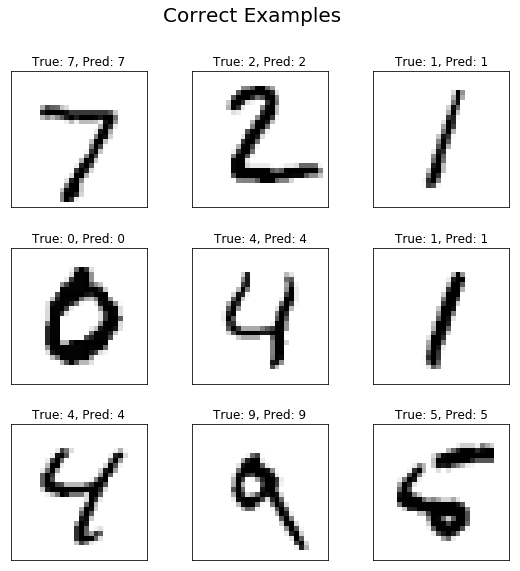

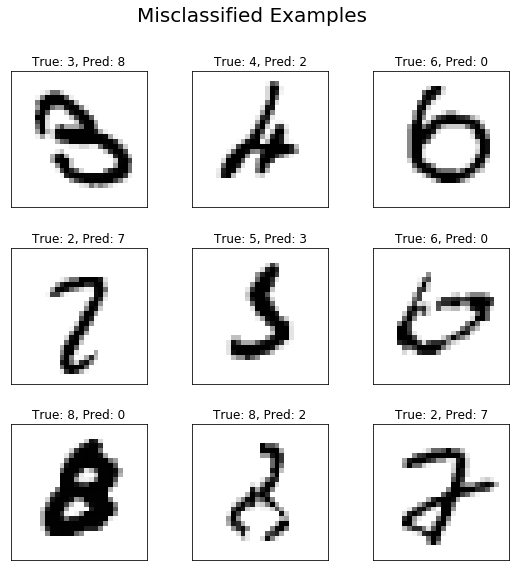

In [8]:
# Test the network after training
# Accuracy
feed_dict_test = {x: mnist.test.images, y: mnist.test.labels}
loss_test, acc_test = sess.run([loss, accuracy], feed_dict=feed_dict_test)
print('---------------------------------------------------------')
print("Test loss: {0:.2f}, test accuracy: {1:.01%}".format(loss_test, acc_test))
print('---------------------------------------------------------')

# Plot some of the correct and misclassified examples
cls_pred = sess.run(cls_prediction, feed_dict=feed_dict_test)
cls_true = np.argmax(mnist.test.labels, axis=1)
plot_images(mnist.test.images, cls_true, cls_pred, title='Correct Examples')
plot_example_errors(mnist.test.images, cls_true, cls_pred, title='Misclassified Examples')

After we are finished the testing, we will close the session to free the memory.

In [9]:
# close the session after you are done with testing
sess.close()

At this step our coding is done. We have also plotted the accuarcy and some examples. But to inspect more in our network, we can run the __Tensorboard__. Open your terminal and type:
```bash
tensorboard --logdir=logs/write_summaries --host localhost
```
and Open the generated link in your browser.

__NOTE:__ Don't forget to activate your environment !!!

You can see the images, scalars and histograms in added tabs:

__Image summaries:__
![Alt text](files/image_summaries.png)

__Scalar summaries:__
![Alt text](files/scalar_summaries.png)

__Histogram summaries:__
![Alt text](files/hist_summaries.png)


Thanks for reading! If you have any question or doubt, feel free to leave a comment in our [website](http://easy-tensorflow.com/).